In [106]:
# import librarties 
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import nltk 
#import spacy
import string
import time
#import gensim
from gensim.models import KeyedVectors
from tqdm import tqdm_notebook
import os
from os import listdir 
import matplotlib.pyplot as plt 
from torch.optim import Adam
from ast import literal_eval
from datetime import datetime
from sklearn.metrics import confusion_matrix
pd.set_option('max_colwidth',100)
import matplotlib.style
import matplotlib as mpl
mpl.style.use('bmh')

In [3]:
random.seed(134)
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 64
MAX_VOCAB_SIZE = 50000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# Data Processing

### Build vocab from pretrained word embeddings

In [4]:
# build vocab from fasttext embeddings 

def build_vocab(word2vec_source, max_vocab_size): 
    """ Takes pretrained word2vec source path, limits to max_vocab_size, and returns:  
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices 
        - word_emb: dictionary representing word embeddings 
    """
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_source, limit=max_vocab_size)
    id2token = word2vec_model.index2word
    token2id = dict(zip(id2token, range(2, 2+len(id2token))))
    id2token = ['<pad>', '<unk>'] + id2token 
    word_emb = {token2id[w]: word2vec_model[w] for w in word2vec_model.vocab}

    return id2token, token2id, word_emb 

In [5]:
id2token, token2id, word_emb = build_vocab('fasttext_word2vec/wiki-news-300d-1M.vec', MAX_VOCAB_SIZE)

In [6]:
# convert word_emb from dict to matrix 
pretrained_weights = np.zeros((MAX_VOCAB_SIZE+2, 300))
for idx in word_emb: 
    try: 
        pretrained_weights[idx] = word_emb[idx]
    except KeyError: 
        pretrained_weights[idx] = np.random.normal(size=(300,))
pretrained_weights = torch.from_numpy(pretrained_weights.astype(np.float32)).to(device)

### Load data and convert to indices

In [7]:
# load data into pandas dataframe 
snli_train = pd.read_table('hw2_data/snli_train.tsv')
snli_val = pd.read_table('hw2_data/snli_val.tsv')
mnli_train = pd.read_table('hw2_data/mnli_train.tsv')
mnli_val = pd.read_table('hw2_data/mnli_val.tsv')
print(len(snli_train), len(snli_val), len(mnli_train), len(mnli_val))

100000 1000 20000 5000


In [8]:
snli_train.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock viewing a body of water .,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her is focused on a blue object with a pattern on it .,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and tenants,neutral
3,a man in white shorts and a black shirt is paragliding on the ocean,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green grass .,Four dogs are preparing to be launched into space .,contradiction


In [9]:
# helper methods to convert pandas df to lists of word indices and labels 

label_dict = {'contradiction': 0, 'neutral': 1, 'entailment': 2}

def token_to_index_datum(datum_tokens, token2id): 
    """ Converts a list of tokens and converts it to a list of token indices for one datum """ 
    index_list = [token2id[token] if token in token2id else UNK_IDX for token in datum_tokens]
    return index_list 

def df_to_list(data_df, token2id): 
    """ Takes train/val data as pandas df and returns: 
        - list of lists of word indices representing first sentence 
        - list of lists of word indices representing second sentence 
        - list of ground truth labels indicating entailment/contradiction/neutrality of two sentences 
    """
    sent1 = [token_to_index_datum(sent.split(), token2id) for sent in data_df['sentence1'].tolist()] 
    sent2 = [token_to_index_datum(sent.split(), token2id) for sent in data_df['sentence2'].tolist()] 
    labels = [label_dict[label] for label in data_df['label'].tolist()] 
    return sent1, sent2, labels

In [10]:
# convert data to indices 
snli_train_sent1, snli_train_sent2, snli_train_labels = df_to_list(snli_train, token2id)
snli_val_sent1, snli_val_sent2, snli_val_labels = df_to_list(snli_val, token2id)
mnli_train_sent1, mnli_train_sent2, mnli_train_labels = df_to_list(mnli_train, token2id)
mnli_val_sent1, mnli_val_sent2, mnli_val_labels = df_to_list(mnli_val, token2id)

Text(0,0.5,'Label')

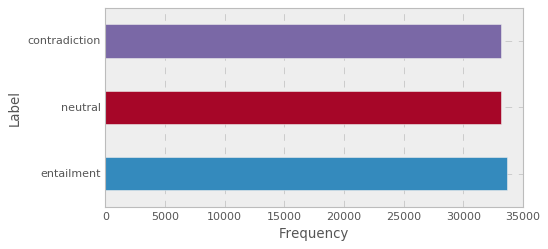

In [107]:
# check distribution of labels 
plt.figure(figsize=(6, 3))
snli_train['label'].value_counts().plot(kind='barh')
plt.xlabel('Frequency')
plt.ylabel('Label')

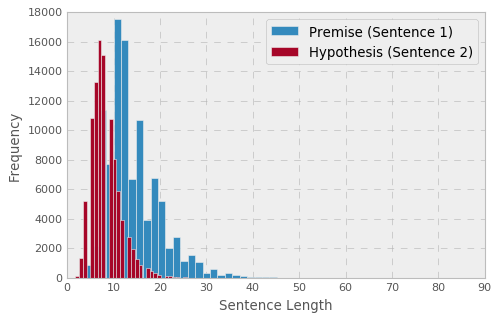

In [108]:
# check distribution of sentence lengths 
plt.figure(figsize=(6, 4))
snli_train['sentence1'].apply(lambda x: x.split()).apply(len).hist(bins=50, label='Premise (Sentence 1)')
snli_train['sentence2'].apply(lambda x: x.split()).apply(len).hist(bins=50, label='Hypothesis (Sentence 2)')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()

In [57]:
# based on results above, we set our max_sentence_length to 40 which covers all of sentence2 and most of sentence1 
MAX_SENTENCE_LENGTH = 40

### Build PyTorch Dataloader 

In [58]:
# helper functions to create dataloader 

class SNLI_Dataset(Dataset): 
    """ 
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset    
    """
    
    def __init__(self, sent1_list, sent2_list, label_list): 
        """ 
        Initialize dataset by passing in the sent and label lists, along with max_sent_length 
        """
        self.sent1_list = sent1_list
        self.sent2_list = sent2_list 
        self.label_list = label_list
        assert (len(self.sent1_list) == len(self.sent2_list) == len(self.label_list))
        
    def __len__(self): 
        return len(self.label_list)
    
    def __getitem__(self, key): 
        """
        Triggered when dataset[i] is called, outputs a list of tokens, lengths of lists, and label of the data point
        """
        sent1_idx = self.sent1_list[key][:MAX_SENTENCE_LENGTH]
        sent2_idx = self.sent2_list[key][:MAX_SENTENCE_LENGTH]    
        sent1_len = len(sent1_idx)
        sent2_len = len(sent2_idx)
        label = self.label_list[key]
        return [sent1_idx, sent2_idx, sent1_len, sent2_len, label]
    
def collate_func(batch): 
    """Customized function for DataLoader that dynamically pads the batch 
       so that all data have the same length""" 
    
    sents1 = [] 
    sents2 = [] 
    sent1_lens = [] 
    sent2_lens = [] 
    labels = [] 

    for datum in batch:
        sent1_lens.append(datum[2])
        sent2_lens.append(datum[3])
        labels.append(datum[4])
        
        # pad data before appending 
        padded_vec1 = np.pad(array=np.array(datum[0]), 
                             pad_width = ((0, MAX_SENTENCE_LENGTH - datum[2])), 
                             mode = 'constant', constant_values = 0)
        padded_vec2 = np.pad(array=np.array(datum[1]), 
                             pad_width = ((0, MAX_SENTENCE_LENGTH - datum[3])), 
                             mode = 'constant', constant_values = 0)
        sents1.append(padded_vec1)
        sents2.append(padded_vec2)
        
    return [torch.from_numpy(np.array(sents1)), torch.from_numpy(np.array(sents2)), 
            torch.LongTensor(sent1_lens), torch.LongTensor(sent2_lens), torch.LongTensor(labels)]

def create_data_loader(sent1_list, sent2_list, label_list): 
    """ Takes index lists of sentence1, setence2, and labels for a given dataset and returns a data loader """
    data_set = SNLI_Dataset(sent1_list, sent2_list, label_list)
    data_loader = torch.utils.data.DataLoader(dataset=data_set, batch_size=BATCH_SIZE, 
                                              collate_fn=collate_func, shuffle=False)
    return data_loader 

In [59]:
# create data loaders 
snli_train_loader = create_data_loader(snli_train_sent1, snli_train_sent2, snli_train_labels)
snli_val_loader = create_data_loader(snli_val_sent1, snli_val_sent2, snli_val_labels)
mnli_train_loader = create_data_loader(mnli_train_sent1, mnli_train_sent2, mnli_train_labels)
mnli_val_loader = create_data_loader(mnli_val_sent1, mnli_val_sent2, mnli_val_labels)

In [60]:
for i, (sent1_idx, sent2_idx, sent1_len, sent2_len, label) in enumerate(snli_train_loader):
    print(i)
    print(sent1_idx)
    print(sent2_idx)
    print(sent1_len)
    print(sent2_len)
    print(label)
    break 

0
tensor([[  106,   802,  1830,  ...,     0,     0,     0],
        [  106,   994,    15,  ...,     0,     0,     0],
        [17790,     3,  1938,  ...,     0,     0,     0],
        ...,
        [ 3799,  5700,  5367,  ...,     0,     0,     0],
        [ 2129,    34, 14364,  ...,     0,     0,     0],
        [  106,  5895,   194,  ...,     0,     0,     0]])
tensor([[ 106,  802, 1830,  ...,    0,    0,    0],
        [1442,   67,   34,  ...,    0,    0,    0],
        [  22,  542,  402,  ...,    0,    0,    0],
        ...,
        [  22, 5700,   34,  ...,    0,    0,    0],
        [ 106,  347, 2784,  ...,    0,    0,    0],
        [ 106,  347, 5822,  ...,    0,    0,    0]])
tensor([17, 22, 11, 14, 10, 13, 10,  7, 18, 32, 13, 13, 30, 13, 17, 10, 26, 17,
         8, 13,  8, 13,  8, 25,  9, 15, 12,  7, 21, 10,  9, 10, 10, 10,  9, 24,
        11, 24, 16,  8,  8,  9, 15, 19, 15, 12, 10, 34, 12, 10, 22, 13,  7, 12,
        19, 16, 13,  9, 13, 20, 11, 19, 31, 30])
tensor([10,  8,  9, 1

# Model Architecture

### RNN (Single-Layer GRU)

In [61]:
# Bi-Directional GRU - with packing of padded seq 

class rnn_model(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_out_size, num_classes, 
                 pretrained_weights, bidirectional=True):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super().__init__() 
        self.num_layers, self.hidden_size, self.bidirectional = num_layers, hidden_size, bidirectional
        self.embedding1 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.embedding2 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.rnn1 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear(2*2*hidden_size, fc_out_size)
        self.fc2 = nn.Linear(fc_out_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        if self.bidirectional: 
            hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
        else: 
            hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)

        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        # reset hidden state

        batch_size = x1.size()[0]

        # run sentence 1 
        _, idx_sort1 = torch.sort(x1_lengths, dim=0, descending=True)
        _, idx_unsort1 = torch.sort(idx_sort1, dim=0)
        x1, x1_lengths = x1.index_select(0, idx_sort1), x1_lengths.index_select(0, idx_sort1)
        embed1 = self.embedding1(x1)
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, x1_lengths, batch_first=True)
        self.hidden1 = self.init_hidden(batch_size).to(device)      
        rnn1_out, self.hidden1 = self.rnn1(embed1, self.hidden1)
        rnn1_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn1_out, batch_first=True)
#        print(rnn1_out.size(), self.hidden1.size())
        rnn1_out_final = torch.cat([rnn1_out[:, -1, :self.hidden_size], rnn1_out[:, 0, self.hidden_size:]], dim=1) 
        rnn1_out_final = rnn1_out_final.index_select(0, idx_unsort1)
        
        # run sentence 2 
        _, idx_sort2 = torch.sort(x2_lengths, dim=0, descending=True)
        _, idx_unsort2 = torch.sort(idx_sort2, dim=0)
        x2, x2_lengths = x2.index_select(0, idx_sort2), x2_lengths.index_select(0, idx_sort2)
        embed2 = self.embedding2(x2)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, x2_lengths, batch_first=True)
        self.hidden2 = self.init_hidden(batch_size).to(device)
        rnn2_out, self.hidden2 = self.rnn2(embed2, self.hidden2)
        rnn2_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn2_out, batch_first=True)
        rnn2_out_final = torch.cat([rnn2_out[:, -1, :self.hidden_size], rnn2_out[:, 0, self.hidden_size:]], dim=1) 
        rnn2_out_final = rnn2_out_final.index_select(0, idx_unsort2)

        # concat outputs from both RNNs and run them through FC layers 
        combined = torch.cat([rnn1_out_final, rnn2_out_final], dim=1)
        output = F.relu(self.fc1(combined))
        logits = self.fc2(output) 

        return logits 

### CNN

In [62]:
# 2-layer 1D CNN with ReLU activations 

class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_out_size, num_classes, pretrained_weights):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        
        self.embedding1 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.conv11 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv12 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        
        self.embedding2 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.conv21 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv22 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)    
        
        self.fc1 = nn.Linear(2*hidden_size, fc_out_size)
        self.fc2 = nn.Linear(fc_out_size, num_classes)

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        batch_size, seq_len = x1.size()

        embed1 = self.embedding1(x1)
        hidden1 = self.conv11(embed1.transpose(1,2)).transpose(1,2)
#        hidden1 = F.leaky_relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.conv12(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.leaky_relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        #hidden1 = torch.sum(hidden1, dim=1)
        hidden1 = torch.max(hidden1, dim=1)[0]

        embed2 = self.embedding2(x2)
        hidden2 = self.conv21(embed2.transpose(1,2)).transpose(1,2)
#        hidden2 = F.leaky_relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.conv22(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.leaky_relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
#        hidden2 = torch.sum(hidden2, dim=1)
        hidden2 = torch.max(hidden2, dim=1)[0]
        
        # concat outputs from both RNNs and run them through FC layers 
        combined = torch.cat([hidden1, hidden2], dim=1)
        output = F.relu(self.fc1(combined))
        logits = self.fc2(output) 
        
        return logits

# Model Training 

In [70]:
# helper functions to train and test model - old 

def test_model(loader, model): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    correct = 0 
    total = 0 
    model.eval() 
    all_predictions = [] 
    all_labels = [] 
    
    for sent1s, sent2s, sent1_lens, sent2_lens, labels in loader: 
        sent1s, sent2s, sent1_lens, sent2_lens, labels = sent1s.to(device), sent2s.to(device), sent1_lens.to(device), sent2_lens.to(device), labels.to(device)
        outputs = F.softmax(model(sent1s, sent2s, sent1_lens, sent2_lens), dim=1)
        predictions = outputs.max(1, keepdim=True)[1]    
        total += labels.size(0)
        correct += predictions.eq(labels.view_as(predictions)).sum().item()
        all_predictions += list(predictions.flatten()) 
        all_labels += list(labels.flatten())
        
    return (100 * correct / total), all_predictions, all_labels 


def train_and_eval(model, train_loader, val_loader, num_epochs, learning_rate, print_intermediate=True, 
                   save_checkpoint=False, model_name='default'):  
    """
    Trains model on data from train_loader and evaluates on data from val_loader for num_epochs 
    Returns results as a dictionary comprising epoch, train accuracy, and validation accuracy 
    """
    # train and validate 
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    results = []
    for epoch in range(num_epochs):
        for i, (sent1s, sent2s, sent1_lens, sent2_lens, labels) in enumerate(train_loader):
            model.to(device)
            model.train()
            optimizer.zero_grad()
            sent1s, sent2s, sent1_lens, sent2_lens, labels = sent1s.to(device), sent2s.to(device), sent1_lens.to(device), sent2_lens.to(device), labels.to(device)
            outputs = model(sent1s, sent2s, sent1_lens, sent2_lens)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i % 100 == 0 or ((epoch==num_epochs-1) & (i==len(train_loader)-1)):
                result = {} 
                result['epoch'] = epoch + i / len(train_loader)
                result['train_acc'], _, _ = test_model(train_loader, model)
                result['val_acc'], _, _ = test_model(val_loader, model)       
                results.append(result)

                if save_checkpoint: 
                    checkpoint_fp = 'model_checkpoints/{}.pth.tar'.format(model_name)
                    torch.save(model.state_dict(), checkpoint_fp)
                
                if print_intermediate: 
                    print('Epoch: {:.2f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(
                        result['epoch'], result['train_acc'], result['val_acc']))
    return results 

In [81]:
# helper functions to train and test model - save model if best  

def test_model(loader, model): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    correct = 0 
    total = 0 
    model.eval() 
    all_predictions = [] 
    all_labels = [] 
    
    for sent1s, sent2s, sent1_lens, sent2_lens, labels in loader: 
        sent1s, sent2s, sent1_lens, sent2_lens, labels = sent1s.to(device), sent2s.to(device), sent1_lens.to(device), sent2_lens.to(device), labels.to(device)
        outputs = F.softmax(model(sent1s, sent2s, sent1_lens, sent2_lens), dim=1)
        predictions = outputs.max(1, keepdim=True)[1]    
        total += labels.size(0)
        correct += predictions.eq(labels.view_as(predictions)).sum().item()
        all_predictions += list(predictions.flatten()) 
        all_labels += list(labels.flatten())
        
    return (100 * correct / total), all_predictions, all_labels 


def train_and_eval(model, train_loader, val_loader, num_epochs, learning_rate, print_intermediate=True, 
                   save_checkpoint=False, model_name='default'):  
    """
    Trains model on data from train_loader and evaluates on data from val_loader for num_epochs 
    Returns results as a dictionary comprising epoch, train accuracy, and validation accuracy 
    """
    # train and validate 
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    results = []
    for epoch in range(num_epochs):
        for i, (sent1s, sent2s, sent1_lens, sent2_lens, labels) in enumerate(train_loader):
            model.to(device)
            model.train()
            optimizer.zero_grad()
            sent1s, sent2s, sent1_lens, sent2_lens, labels = sent1s.to(device), sent2s.to(device), sent1_lens.to(device), sent2_lens.to(device), labels.to(device)
            outputs = model(sent1s, sent2s, sent1_lens, sent2_lens)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i % 100 == 0 or ((epoch==num_epochs-1) & (i==len(train_loader)-1)):
                result = {} 
                result['epoch'] = epoch + i / len(train_loader)
                result['train_acc'], _, _ = test_model(train_loader, model)
                result['val_acc'], _, _ = test_model(val_loader, model)       
                results.append(result)

                if save_checkpoint: 
                    if result['val_acc'] == pd.DataFrame.from_dict(results)['val_acc'].max(): 
                        checkpoint_fp = 'model_checkpoints/{}.pth.tar'.format(model_name)
                        torch.save(model.state_dict(), checkpoint_fp)
                
                if print_intermediate: 
                    print('Epoch: {:.2f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(
                        result['epoch'], result['train_acc'], result['val_acc']))
    return results 

In [73]:
# helper functions to save results to and load results from a pkl logfile 

RESULTS_LOG = 'experiment_results/experiment_results_log_v4_gcp.pkl'

def append_to_log(hyperparams, results, runtime, experiment_name, filename=RESULTS_LOG): 
    """ Appends results and details of a single experiment to a log file """
    
    # create directory if doesn't already exist 
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
        
    # store experiment details in a dictionary 
    new_result = {'experiment_name': experiment_name, 'hyperparams': hyperparams, 'results': results, 
                  'runtime': runtime, 'dt_created': datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    
    # if log already exists, append to log 
    try: 
        results_log = pkl.load(open(filename, "rb"))
        results_log.append(new_result)

    # if log doesn't exists, initialize first result as the log 
    except (OSError, IOError) as e:
        results_log = [new_result]
    
    # save to pickle 
    pkl.dump(results_log, open(filename, "wb"))

In [74]:
def load_experiment_log(experiment_name=None, filename=RESULTS_LOG): 
    """ Loads experiment log, with option to filter for a specific experiment_name """
    
    results_log = pkl.load(open(filename, "rb"))
    
    if experiment_name is not None: 
        results_log = [r for r in results_log if r['experiment_name'] == experiment_name]
        
    return results_log 

In [75]:
def run_experiment(train_loader, val_loader, model_type, hidden_size, fc_out_size, kernel_size,  
                   learning_rate, num_epochs, experiment_name='Not_Specified', 
                   save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True):  
    
    """ Wraps all processing, training and evaluation steps in a function to facilitate hyperparam tuning. 
        Note that the function takes as input tokenized data rather than raw data since there's significant 
        lag time in generating tokens.  
    """
    
    start_time = time.time() 
    
    # instantiate model and optimizer 
    if model_type == 'rnn': 
        model = rnn_model(emb_size=300, hidden_size=hidden_size, num_layers=1, fc_out_size=fc_out_size, 
                          num_classes=3, pretrained_weights=pretrained_weights)
    elif model_type == 'cnn': 
        model = CNN(emb_size=300, hidden_size=hidden_size, num_layers=2, fc_out_size=fc_out_size, 
                    num_classes=3, pretrained_weights=pretrained_weights)
    else: 
        raise ValueError("Invalid model_type. Must be either 'cnn' or 'rnn'")
        
    # train and evaluate 
    results = train_and_eval(model, train_loader, val_loader, num_epochs, learning_rate, 
                             print_intermediate=print_intermediate, save_checkpoint=save_checkpoint, 
                             model_name=experiment_name)
    
    # store, print, and save results 
    runtime = time.time() - start_time 
    hyperparams = {'model_type': model_type, 'hidden_size': hidden_size, 'fc_out_size': fc_out_size, 
                   'kernel_size': kernel_size, 'learning_rate': learning_rate, 'num_epochs': num_epochs}
    if save_to_log: 
        append_to_log(hyperparams, results, runtime, experiment_name)
    if print_summary: 
        print("Experiment completed in {} seconds with {}% validation accuracy.".format(
            int(runtime), pd.DataFrame.from_dict(results)['val_acc'].max()))
        
    return results, hyperparams, runtime, model, train_loader, val_loader 

In [139]:
# helper methods to summarize, evaluate, and plot results 

def summarize_results(results_log): 
    """ Summarizes results_log (list) into a dataframe, splitting hyperparameters string into columns, and reducing 
        the val_acc dict into the best validation accuracy obtained amongst all the epochs logged """
    results_df = pd.DataFrame.from_dict(results_log)
    results_df = pd.concat([results_df, results_df['hyperparams'].apply(pd.Series)], axis=1)
    results_df['val_acc'] = results_df['results'].apply(lambda d: pd.DataFrame.from_dict(d)['val_acc'].max())
    return results_df.sort_values(by='val_acc', ascending=False) 

def plot_multiple_learning_curves(results_df, plot_variable, figsize=(8, 5), legend_loc='best'):
    """ Plots learning curves of MULTIPLE experiments, includes only validation accuracy """
    plt.figure(figsize=figsize)
    for index, row in results_df.iterrows():
        val_acc_hist = pd.DataFrame.from_dict(row['results']).set_index('epoch')['val_acc'] 
        plt.plot(val_acc_hist, label="{} ({}%)".format(row[plot_variable], val_acc_hist.max()))
    plt.legend(title=plot_variable, loc=legend_loc)    
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')

def plot_single_learning_curve(results, figsize=(8, 5)): 
    """ Plots learning curve of a SINGLE experiment, includes both train and validation accuracy """
    results_df = pd.DataFrame.from_dict(results)
    results_df = results_df.set_index('epoch')
    results_df.plot(figsize=figsize)
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')

### Tune RNN 

In [77]:
rnn_hidden_fc_out_size_exps = summarize_results(load_experiment_log(experiment_name='RNN_hidden_fc_out_10epoch', filename=RESULTS_LOG))
rnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'num_epochs', 'runtime', 'val_acc']].sort_values(['hidden_size', 'fc_out_size'])

,hidden_size,fc_out_size,num_epochs,runtime,val_acc
0,10,100,10,4990.122962,65.6
1,10,200,10,4986.884784,66.5
2,10,300,10,4988.352905,65.8
3,10,500,10,4971.827927,67.1
18,10,750,10,4868.989161,68.0
4,25,100,10,5142.905879,69.3
5,25,200,10,5104.477565,69.2
6,25,300,10,5092.012776,69.8
7,25,500,10,5101.603528,68.8
19,25,750,10,4958.269207,68.8


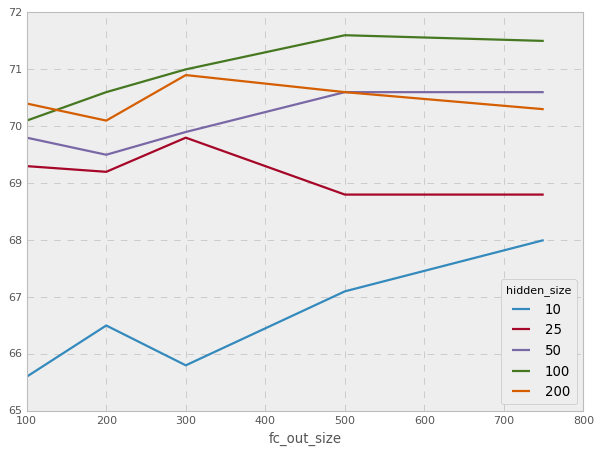

In [109]:
pd.pivot_table(rnn_hidden_fc_out_size_exps, values='val_acc', index='fc_out_size', columns='hidden_size').plot()

In [ ]:
hidden_sizes = [10, 25, 50, 100]

for hidden_size in hidden_sizes: 
    print ("Training with hidden_size = {} ...".format(hidden_size))
    
    # train and evaluate
    results, hyperparams, runtime, _, _, _ = run_experiment(
        train_loader=snli_train_loader, val_loader=snli_val_loader,
        model_type='rnn', hidden_size=hidden_size, fc_out_size=10, kernel_size=None, 
        learning_rate=0.01, num_epochs=10, experiment_name='RNN_hidden_sizes_10epoch', 
        save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

Training with hidden_size = 10 ...
Epoch: 0.00, Train Accuracy: 33.63%, Validation Accuracy: 33.10%


In [99]:
rnn_hidden_exps = summarize_results(load_experiment_log(experiment_name='RNN_hidden_sizes_10epoch', filename=RESULTS_LOG))
rnn_hidden_exps[['hidden_size', 'num_epochs', 'runtime', 'val_acc']]

,hidden_size,num_epochs,runtime,val_acc
1,25,10,5058.904662,66.0
2,50,10,5169.065293,65.5
0,10,10,5040.181450,63.9
3,100,10,5343.212260,62.7


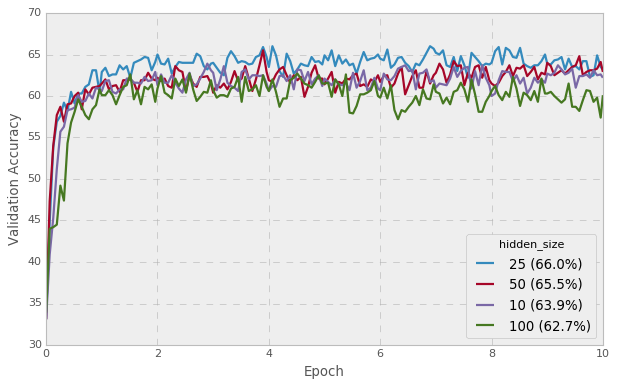

In [111]:
plot_multiple_learning_curves(rnn_hidden_exps, 'hidden_size', legend_loc='lower right')

In [59]:
#fc_out_sizes = [10, 25, 50, 100]

fc_out_sizes = [150, 200, 300, 500]

for fc_out_size in fc_out_sizes: 
    print ("Training with hidden_size = {} ...".format(hidden_size))
    
    # train and evaluate
    results, hyperparams, runtime, _, _, _ = run_experiment(
        train_loader=snli_train_loader, val_loader=snli_val_loader,
        model_type='rnn', hidden_size=25, fc_out_size=fc_out_size, kernel_size=None, 
        learning_rate=0.001, num_epochs=10, experiment_name='RNN_fc_out_sizes_10epoch', 
        save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

Training with hidden_size = 100 ...
Epoch: 0.00, Train Accuracy: 34.48%, Validation Accuracy: 34.10%
Epoch: 0.06, Train Accuracy: 41.38%, Validation Accuracy: 40.50%
Epoch: 0.13, Train Accuracy: 46.92%, Validation Accuracy: 46.40%
Epoch: 0.19, Train Accuracy: 50.25%, Validation Accuracy: 50.30%
Epoch: 0.26, Train Accuracy: 52.40%, Validation Accuracy: 52.40%
Epoch: 0.32, Train Accuracy: 53.01%, Validation Accuracy: 52.10%
Epoch: 0.38, Train Accuracy: 53.98%, Validation Accuracy: 54.20%
Epoch: 0.45, Train Accuracy: 55.66%, Validation Accuracy: 55.20%
Epoch: 0.51, Train Accuracy: 56.39%, Validation Accuracy: 56.90%
Epoch: 0.58, Train Accuracy: 56.30%, Validation Accuracy: 54.20%
Epoch: 0.64, Train Accuracy: 57.35%, Validation Accuracy: 57.50%
Epoch: 0.70, Train Accuracy: 57.46%, Validation Accuracy: 58.70%
Epoch: 0.77, Train Accuracy: 57.96%, Validation Accuracy: 58.40%
Epoch: 0.83, Train Accuracy: 58.53%, Validation Accuracy: 56.20%
Epoch: 0.90, Train Accuracy: 58.80%, Validation Accura

Epoch: 8.06, Train Accuracy: 71.58%, Validation Accuracy: 67.90%
Epoch: 8.13, Train Accuracy: 71.81%, Validation Accuracy: 66.90%
Epoch: 8.19, Train Accuracy: 71.45%, Validation Accuracy: 67.40%
Epoch: 8.26, Train Accuracy: 71.86%, Validation Accuracy: 67.30%
Epoch: 8.32, Train Accuracy: 71.57%, Validation Accuracy: 68.70%
Epoch: 8.38, Train Accuracy: 70.59%, Validation Accuracy: 65.90%
Epoch: 8.45, Train Accuracy: 71.98%, Validation Accuracy: 67.70%
Epoch: 8.51, Train Accuracy: 71.90%, Validation Accuracy: 66.60%
Epoch: 8.58, Train Accuracy: 71.69%, Validation Accuracy: 67.60%
Epoch: 8.64, Train Accuracy: 72.20%, Validation Accuracy: 69.00%
Epoch: 8.70, Train Accuracy: 71.83%, Validation Accuracy: 67.70%
Epoch: 8.77, Train Accuracy: 72.07%, Validation Accuracy: 67.50%
Epoch: 8.83, Train Accuracy: 72.20%, Validation Accuracy: 67.00%
Epoch: 8.90, Train Accuracy: 72.08%, Validation Accuracy: 67.30%
Epoch: 8.96, Train Accuracy: 72.31%, Validation Accuracy: 69.30%
Epoch: 9.00, Train Accura

Epoch: 5.83, Train Accuracy: 70.10%, Validation Accuracy: 65.90%
Epoch: 5.90, Train Accuracy: 70.09%, Validation Accuracy: 67.60%
Epoch: 5.96, Train Accuracy: 70.44%, Validation Accuracy: 67.70%
Epoch: 6.00, Train Accuracy: 69.84%, Validation Accuracy: 66.50%
Epoch: 6.06, Train Accuracy: 70.47%, Validation Accuracy: 67.40%
Epoch: 6.13, Train Accuracy: 70.18%, Validation Accuracy: 67.20%
Epoch: 6.19, Train Accuracy: 70.14%, Validation Accuracy: 65.90%
Epoch: 6.26, Train Accuracy: 70.74%, Validation Accuracy: 65.90%
Epoch: 6.32, Train Accuracy: 70.38%, Validation Accuracy: 67.50%
Epoch: 6.38, Train Accuracy: 69.70%, Validation Accuracy: 66.30%
Epoch: 6.45, Train Accuracy: 70.84%, Validation Accuracy: 68.10%
Epoch: 6.51, Train Accuracy: 71.06%, Validation Accuracy: 68.80%
Epoch: 6.58, Train Accuracy: 70.73%, Validation Accuracy: 66.10%
Epoch: 6.64, Train Accuracy: 70.86%, Validation Accuracy: 67.70%
Epoch: 6.70, Train Accuracy: 71.05%, Validation Accuracy: 67.10%
Epoch: 6.77, Train Accura

Epoch: 4.00, Train Accuracy: 67.56%, Validation Accuracy: 63.90%
Epoch: 4.06, Train Accuracy: 67.73%, Validation Accuracy: 64.90%
Epoch: 4.13, Train Accuracy: 68.06%, Validation Accuracy: 64.90%
Epoch: 4.19, Train Accuracy: 68.01%, Validation Accuracy: 65.10%
Epoch: 4.26, Train Accuracy: 68.25%, Validation Accuracy: 66.00%
Epoch: 4.32, Train Accuracy: 68.11%, Validation Accuracy: 65.90%
Epoch: 4.38, Train Accuracy: 68.00%, Validation Accuracy: 65.10%
Epoch: 4.45, Train Accuracy: 68.62%, Validation Accuracy: 65.60%
Epoch: 4.51, Train Accuracy: 68.71%, Validation Accuracy: 66.30%
Epoch: 4.58, Train Accuracy: 68.78%, Validation Accuracy: 66.10%
Epoch: 4.64, Train Accuracy: 68.84%, Validation Accuracy: 67.00%
Epoch: 4.70, Train Accuracy: 68.85%, Validation Accuracy: 66.60%
Epoch: 4.77, Train Accuracy: 68.95%, Validation Accuracy: 66.50%
Epoch: 4.83, Train Accuracy: 69.25%, Validation Accuracy: 65.30%
Epoch: 4.90, Train Accuracy: 69.29%, Validation Accuracy: 66.00%
Epoch: 4.96, Train Accura

Epoch: 2.00, Train Accuracy: 62.09%, Validation Accuracy: 60.40%
Epoch: 2.06, Train Accuracy: 63.08%, Validation Accuracy: 61.20%
Epoch: 2.13, Train Accuracy: 63.18%, Validation Accuracy: 60.80%
Epoch: 2.19, Train Accuracy: 63.49%, Validation Accuracy: 62.20%
Epoch: 2.26, Train Accuracy: 64.06%, Validation Accuracy: 62.40%
Epoch: 2.32, Train Accuracy: 63.89%, Validation Accuracy: 63.70%
Epoch: 2.38, Train Accuracy: 64.01%, Validation Accuracy: 61.20%
Epoch: 2.45, Train Accuracy: 64.53%, Validation Accuracy: 62.60%
Epoch: 2.51, Train Accuracy: 64.41%, Validation Accuracy: 63.40%
Epoch: 2.58, Train Accuracy: 64.78%, Validation Accuracy: 61.40%
Epoch: 2.64, Train Accuracy: 65.08%, Validation Accuracy: 63.20%
Epoch: 2.70, Train Accuracy: 64.95%, Validation Accuracy: 64.40%
Epoch: 2.77, Train Accuracy: 65.14%, Validation Accuracy: 62.20%
Epoch: 2.83, Train Accuracy: 65.64%, Validation Accuracy: 63.00%
Epoch: 2.90, Train Accuracy: 65.91%, Validation Accuracy: 63.20%
Epoch: 2.96, Train Accura

Epoch: 9.96, Train Accuracy: 74.44%, Validation Accuracy: 67.20%
Epoch: 10.00, Train Accuracy: 74.01%, Validation Accuracy: 67.20%
Experiment completed in 5000 seconds with 69.6% validation accuracy.


In [102]:
rnn_fc_out_size_exps = summarize_results(load_experiment_log(experiment_name='RNN_fc_out_sizes_10epoch', filename=RESULTS_LOG))
rnn_fc_out_size_exps[['fc_out_size', 'num_epochs', 'runtime', 'val_acc']]

,fc_out_size,num_epochs,runtime,val_acc
5,200,10,4987.040472,70.2
7,500,10,5000.534196,69.6
4,150,10,5005.535896,69.3
3,100,10,4985.310119,69.1
6,300,10,4993.956714,69.0
2,50,10,4993.896937,68.4
1,25,10,5007.719239,66.5
0,10,10,5048.078962,65.6


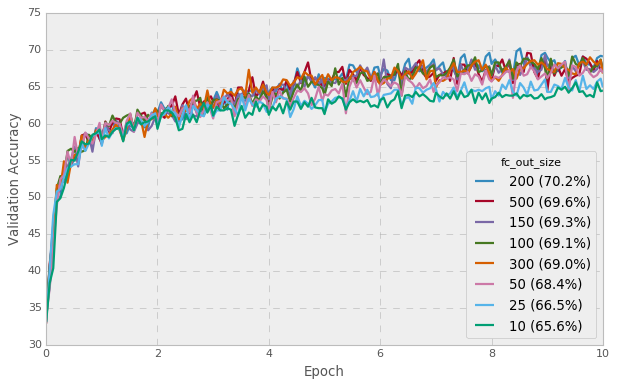

In [112]:
plot_multiple_learning_curves(rnn_fc_out_size_exps, 'fc_out_size', legend_loc='lower right')

In [ ]:
hidden_sizes = [25, 50, 100]
fc_out_sizes = [100, 200, 300, 500]

for hidden_size in hidden_sizes: 
    for fc_out_size in fc_out_sizes: 
        print ("Training with hidden_size = {} and fc_out_size = {} ...".format(hidden_size, fc_out_size))
    
        # train and evaluate
        results, hyperparams, runtime, _, _, _ = run_experiment(
            train_loader=snli_train_loader, val_loader=snli_val_loader,
            model_type='rnn', hidden_size=hidden_size, fc_out_size=fc_out_size, kernel_size=None, 
            learning_rate=0.001, num_epochs=10, experiment_name='RNN_hidden_fc_out_10epoch', 
            save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

Training with hidden_size = 25 and fc_out_size = 100 ...
Epoch: 0.00, Train Accuracy: 33.92%, Validation Accuracy: 33.50%
Epoch: 0.06, Train Accuracy: 41.45%, Validation Accuracy: 40.40%
Epoch: 0.13, Train Accuracy: 46.87%, Validation Accuracy: 45.30%
Epoch: 0.19, Train Accuracy: 50.33%, Validation Accuracy: 50.10%
Epoch: 0.26, Train Accuracy: 52.15%, Validation Accuracy: 50.30%
Epoch: 0.32, Train Accuracy: 52.45%, Validation Accuracy: 50.50%
Epoch: 0.38, Train Accuracy: 53.85%, Validation Accuracy: 55.10%
Epoch: 0.45, Train Accuracy: 55.25%, Validation Accuracy: 53.90%
Epoch: 0.51, Train Accuracy: 56.10%, Validation Accuracy: 55.80%
Epoch: 0.58, Train Accuracy: 56.11%, Validation Accuracy: 55.10%
Epoch: 0.64, Train Accuracy: 56.86%, Validation Accuracy: 57.80%
Epoch: 0.70, Train Accuracy: 57.24%, Validation Accuracy: 56.60%
Epoch: 0.77, Train Accuracy: 57.69%, Validation Accuracy: 56.30%
Epoch: 0.83, Train Accuracy: 58.12%, Validation Accuracy: 58.30%
Epoch: 0.90, Train Accuracy: 58.3

Epoch: 7.90, Train Accuracy: 70.71%, Validation Accuracy: 68.70%
Epoch: 7.96, Train Accuracy: 71.21%, Validation Accuracy: 68.50%
Epoch: 8.00, Train Accuracy: 70.53%, Validation Accuracy: 67.10%
Epoch: 8.06, Train Accuracy: 70.89%, Validation Accuracy: 68.00%
Epoch: 8.13, Train Accuracy: 71.18%, Validation Accuracy: 68.70%
Epoch: 8.19, Train Accuracy: 71.13%, Validation Accuracy: 68.00%
Epoch: 8.26, Train Accuracy: 71.19%, Validation Accuracy: 67.40%
Epoch: 8.32, Train Accuracy: 71.10%, Validation Accuracy: 68.50%
Epoch: 8.38, Train Accuracy: 69.98%, Validation Accuracy: 65.20%
Epoch: 8.45, Train Accuracy: 71.48%, Validation Accuracy: 67.50%
Epoch: 8.51, Train Accuracy: 71.59%, Validation Accuracy: 66.80%
Epoch: 8.58, Train Accuracy: 71.68%, Validation Accuracy: 67.10%
Epoch: 8.64, Train Accuracy: 71.25%, Validation Accuracy: 67.60%
Epoch: 8.70, Train Accuracy: 71.51%, Validation Accuracy: 68.00%
Epoch: 8.77, Train Accuracy: 71.68%, Validation Accuracy: 67.00%
Epoch: 8.83, Train Accura

Epoch: 5.64, Train Accuracy: 70.14%, Validation Accuracy: 68.20%
Epoch: 5.70, Train Accuracy: 69.95%, Validation Accuracy: 67.40%
Epoch: 5.77, Train Accuracy: 70.22%, Validation Accuracy: 65.90%
Epoch: 5.83, Train Accuracy: 70.36%, Validation Accuracy: 66.20%
Epoch: 5.90, Train Accuracy: 70.16%, Validation Accuracy: 66.80%
Epoch: 5.96, Train Accuracy: 70.57%, Validation Accuracy: 66.50%
Epoch: 6.00, Train Accuracy: 70.09%, Validation Accuracy: 66.70%
Epoch: 6.06, Train Accuracy: 70.58%, Validation Accuracy: 66.70%
Epoch: 6.13, Train Accuracy: 70.57%, Validation Accuracy: 66.80%
Epoch: 6.19, Train Accuracy: 70.57%, Validation Accuracy: 66.70%
Epoch: 6.26, Train Accuracy: 70.80%, Validation Accuracy: 66.20%
Epoch: 6.32, Train Accuracy: 70.76%, Validation Accuracy: 66.50%
Epoch: 6.38, Train Accuracy: 70.00%, Validation Accuracy: 66.60%
Epoch: 6.45, Train Accuracy: 71.03%, Validation Accuracy: 67.30%
Epoch: 6.51, Train Accuracy: 70.76%, Validation Accuracy: 68.00%
Epoch: 6.58, Train Accura

Epoch: 3.83, Train Accuracy: 67.08%, Validation Accuracy: 63.90%
Epoch: 3.90, Train Accuracy: 67.27%, Validation Accuracy: 66.00%
Epoch: 3.96, Train Accuracy: 67.73%, Validation Accuracy: 64.40%
Epoch: 4.00, Train Accuracy: 67.07%, Validation Accuracy: 64.50%
Epoch: 4.06, Train Accuracy: 67.24%, Validation Accuracy: 65.90%
Epoch: 4.13, Train Accuracy: 67.60%, Validation Accuracy: 65.80%
Epoch: 4.19, Train Accuracy: 67.82%, Validation Accuracy: 66.70%
Epoch: 4.26, Train Accuracy: 68.15%, Validation Accuracy: 65.80%
Epoch: 4.32, Train Accuracy: 67.81%, Validation Accuracy: 67.30%
Epoch: 4.38, Train Accuracy: 67.14%, Validation Accuracy: 63.80%
Epoch: 4.45, Train Accuracy: 68.27%, Validation Accuracy: 65.70%
Epoch: 4.51, Train Accuracy: 68.49%, Validation Accuracy: 66.80%
Epoch: 4.58, Train Accuracy: 68.46%, Validation Accuracy: 65.80%
Epoch: 4.64, Train Accuracy: 68.79%, Validation Accuracy: 66.80%
Epoch: 4.70, Train Accuracy: 68.50%, Validation Accuracy: 66.60%
Epoch: 4.77, Train Accura

Epoch: 2.26, Train Accuracy: 64.60%, Validation Accuracy: 61.90%
Epoch: 2.32, Train Accuracy: 64.23%, Validation Accuracy: 62.00%
Epoch: 2.38, Train Accuracy: 64.10%, Validation Accuracy: 61.40%
Epoch: 2.45, Train Accuracy: 65.14%, Validation Accuracy: 63.40%
Epoch: 2.51, Train Accuracy: 65.20%, Validation Accuracy: 63.40%
Epoch: 2.58, Train Accuracy: 65.08%, Validation Accuracy: 62.50%
Epoch: 2.64, Train Accuracy: 65.69%, Validation Accuracy: 64.40%
Epoch: 2.70, Train Accuracy: 65.49%, Validation Accuracy: 63.30%
Epoch: 2.77, Train Accuracy: 65.97%, Validation Accuracy: 63.00%
Epoch: 2.83, Train Accuracy: 65.87%, Validation Accuracy: 63.00%
Epoch: 2.90, Train Accuracy: 66.04%, Validation Accuracy: 63.70%
Epoch: 2.96, Train Accuracy: 66.37%, Validation Accuracy: 64.10%
Epoch: 3.00, Train Accuracy: 66.04%, Validation Accuracy: 63.60%
Epoch: 3.06, Train Accuracy: 66.43%, Validation Accuracy: 64.50%
Epoch: 3.13, Train Accuracy: 66.74%, Validation Accuracy: 65.40%
Epoch: 3.19, Train Accura

Epoch: 0.13, Train Accuracy: 48.49%, Validation Accuracy: 49.00%
Epoch: 0.19, Train Accuracy: 51.57%, Validation Accuracy: 52.40%
Epoch: 0.26, Train Accuracy: 52.78%, Validation Accuracy: 52.10%
Epoch: 0.32, Train Accuracy: 53.95%, Validation Accuracy: 53.50%
Epoch: 0.38, Train Accuracy: 55.20%, Validation Accuracy: 55.00%
Epoch: 0.45, Train Accuracy: 56.23%, Validation Accuracy: 55.30%
Epoch: 0.51, Train Accuracy: 57.11%, Validation Accuracy: 57.40%
Epoch: 0.58, Train Accuracy: 57.34%, Validation Accuracy: 55.00%
Epoch: 0.64, Train Accuracy: 57.90%, Validation Accuracy: 57.70%
Epoch: 0.70, Train Accuracy: 58.63%, Validation Accuracy: 57.60%
Epoch: 0.77, Train Accuracy: 58.85%, Validation Accuracy: 57.70%
Epoch: 0.83, Train Accuracy: 58.96%, Validation Accuracy: 57.20%
Epoch: 0.90, Train Accuracy: 59.40%, Validation Accuracy: 58.40%
Epoch: 0.96, Train Accuracy: 59.56%, Validation Accuracy: 59.20%
Epoch: 1.00, Train Accuracy: 59.38%, Validation Accuracy: 59.70%
Epoch: 1.06, Train Accura

Epoch: 8.45, Train Accuracy: 74.15%, Validation Accuracy: 68.60%
Epoch: 8.51, Train Accuracy: 74.08%, Validation Accuracy: 67.60%
Epoch: 8.58, Train Accuracy: 74.11%, Validation Accuracy: 68.20%
Epoch: 8.64, Train Accuracy: 73.94%, Validation Accuracy: 69.00%
Epoch: 8.70, Train Accuracy: 74.34%, Validation Accuracy: 68.00%
Epoch: 8.77, Train Accuracy: 74.40%, Validation Accuracy: 68.70%
Epoch: 8.83, Train Accuracy: 74.38%, Validation Accuracy: 67.90%
Epoch: 8.90, Train Accuracy: 74.46%, Validation Accuracy: 68.20%
Epoch: 8.96, Train Accuracy: 74.63%, Validation Accuracy: 68.30%
Epoch: 9.00, Train Accuracy: 74.13%, Validation Accuracy: 67.60%
Epoch: 9.06, Train Accuracy: 74.32%, Validation Accuracy: 67.30%
Epoch: 9.13, Train Accuracy: 74.47%, Validation Accuracy: 67.50%
Epoch: 9.19, Train Accuracy: 74.82%, Validation Accuracy: 66.50%
Epoch: 9.26, Train Accuracy: 75.15%, Validation Accuracy: 67.80%
Epoch: 9.32, Train Accuracy: 74.85%, Validation Accuracy: 69.80%
Epoch: 9.38, Train Accura

Epoch: 6.19, Train Accuracy: 72.06%, Validation Accuracy: 68.30%
Epoch: 6.26, Train Accuracy: 72.41%, Validation Accuracy: 67.50%
Epoch: 6.32, Train Accuracy: 72.13%, Validation Accuracy: 68.40%
Epoch: 6.38, Train Accuracy: 71.55%, Validation Accuracy: 67.30%
Epoch: 6.45, Train Accuracy: 72.89%, Validation Accuracy: 68.00%
Epoch: 6.51, Train Accuracy: 72.77%, Validation Accuracy: 67.20%
Epoch: 6.58, Train Accuracy: 72.60%, Validation Accuracy: 68.10%
Epoch: 6.64, Train Accuracy: 72.99%, Validation Accuracy: 67.70%
Epoch: 6.70, Train Accuracy: 72.90%, Validation Accuracy: 69.00%
Epoch: 6.77, Train Accuracy: 72.84%, Validation Accuracy: 67.70%
Epoch: 6.83, Train Accuracy: 73.25%, Validation Accuracy: 69.10%
Epoch: 6.90, Train Accuracy: 73.26%, Validation Accuracy: 68.00%
Epoch: 6.96, Train Accuracy: 73.33%, Validation Accuracy: 67.50%
Epoch: 7.00, Train Accuracy: 72.98%, Validation Accuracy: 68.20%
Epoch: 7.06, Train Accuracy: 73.50%, Validation Accuracy: 68.80%
Epoch: 7.13, Train Accura

Epoch: 3.96, Train Accuracy: 69.56%, Validation Accuracy: 67.20%
Epoch: 4.00, Train Accuracy: 68.83%, Validation Accuracy: 65.80%
Epoch: 4.06, Train Accuracy: 69.50%, Validation Accuracy: 66.80%
Epoch: 4.13, Train Accuracy: 69.45%, Validation Accuracy: 66.80%
Epoch: 4.19, Train Accuracy: 69.66%, Validation Accuracy: 66.60%
Epoch: 4.26, Train Accuracy: 69.89%, Validation Accuracy: 66.50%
Epoch: 4.32, Train Accuracy: 69.62%, Validation Accuracy: 67.20%
Epoch: 4.38, Train Accuracy: 69.33%, Validation Accuracy: 65.40%
Epoch: 4.45, Train Accuracy: 70.39%, Validation Accuracy: 67.90%
Epoch: 4.51, Train Accuracy: 70.42%, Validation Accuracy: 67.60%
Epoch: 4.58, Train Accuracy: 70.26%, Validation Accuracy: 68.20%
Epoch: 4.64, Train Accuracy: 70.53%, Validation Accuracy: 67.40%
Epoch: 4.70, Train Accuracy: 70.35%, Validation Accuracy: 68.60%
Epoch: 4.77, Train Accuracy: 70.55%, Validation Accuracy: 67.50%
Epoch: 4.83, Train Accuracy: 70.55%, Validation Accuracy: 66.60%
Epoch: 4.90, Train Accura

Epoch: 1.70, Train Accuracy: 62.45%, Validation Accuracy: 60.10%
Epoch: 1.77, Train Accuracy: 62.63%, Validation Accuracy: 61.00%
Epoch: 1.83, Train Accuracy: 62.95%, Validation Accuracy: 60.10%
Epoch: 1.90, Train Accuracy: 63.63%, Validation Accuracy: 61.50%
Epoch: 1.96, Train Accuracy: 63.64%, Validation Accuracy: 62.00%
Epoch: 2.00, Train Accuracy: 63.17%, Validation Accuracy: 61.10%
Epoch: 2.06, Train Accuracy: 63.81%, Validation Accuracy: 62.10%
Epoch: 2.13, Train Accuracy: 63.96%, Validation Accuracy: 61.90%
Epoch: 2.19, Train Accuracy: 64.22%, Validation Accuracy: 61.00%
Epoch: 2.26, Train Accuracy: 65.22%, Validation Accuracy: 63.60%
Epoch: 2.32, Train Accuracy: 65.30%, Validation Accuracy: 63.20%
Epoch: 2.38, Train Accuracy: 64.98%, Validation Accuracy: 61.10%
Epoch: 2.45, Train Accuracy: 66.03%, Validation Accuracy: 62.70%
Epoch: 2.51, Train Accuracy: 65.60%, Validation Accuracy: 63.70%
Epoch: 2.58, Train Accuracy: 65.96%, Validation Accuracy: 63.50%
Epoch: 2.64, Train Accura

Epoch: 9.64, Train Accuracy: 76.24%, Validation Accuracy: 69.80%
Epoch: 9.70, Train Accuracy: 76.17%, Validation Accuracy: 68.70%
Epoch: 9.77, Train Accuracy: 76.33%, Validation Accuracy: 69.40%
Epoch: 9.83, Train Accuracy: 76.84%, Validation Accuracy: 70.60%
Epoch: 9.90, Train Accuracy: 76.79%, Validation Accuracy: 70.00%
Epoch: 9.96, Train Accuracy: 76.81%, Validation Accuracy: 68.20%
Epoch: 10.00, Train Accuracy: 76.53%, Validation Accuracy: 68.50%
Experiment completed in 5342 seconds with 70.6% validation accuracy.
Training with hidden_size = 100 and fc_out_size = 100 ...
Epoch: 0.00, Train Accuracy: 33.30%, Validation Accuracy: 33.00%
Epoch: 0.06, Train Accuracy: 43.15%, Validation Accuracy: 41.60%
Epoch: 0.13, Train Accuracy: 48.94%, Validation Accuracy: 51.30%
Epoch: 0.19, Train Accuracy: 52.02%, Validation Accuracy: 52.80%
Epoch: 0.26, Train Accuracy: 53.43%, Validation Accuracy: 52.50%
Epoch: 0.32, Train Accuracy: 54.88%, Validation Accuracy: 53.70%
Epoch: 0.38, Train Accuracy

Epoch: 7.38, Train Accuracy: 73.68%, Validation Accuracy: 67.00%
Epoch: 7.45, Train Accuracy: 74.97%, Validation Accuracy: 68.70%
Epoch: 7.51, Train Accuracy: 74.24%, Validation Accuracy: 67.70%
Epoch: 7.58, Train Accuracy: 75.12%, Validation Accuracy: 69.20%
Epoch: 7.64, Train Accuracy: 74.93%, Validation Accuracy: 68.70%
Epoch: 7.70, Train Accuracy: 74.51%, Validation Accuracy: 69.00%
Epoch: 7.77, Train Accuracy: 74.81%, Validation Accuracy: 68.00%
Epoch: 7.83, Train Accuracy: 75.09%, Validation Accuracy: 67.40%
Epoch: 7.90, Train Accuracy: 75.18%, Validation Accuracy: 68.30%
Epoch: 7.96, Train Accuracy: 75.44%, Validation Accuracy: 69.30%
Epoch: 8.00, Train Accuracy: 75.04%, Validation Accuracy: 68.40%
Epoch: 8.06, Train Accuracy: 75.69%, Validation Accuracy: 68.40%
Epoch: 8.13, Train Accuracy: 75.51%, Validation Accuracy: 67.60%
Epoch: 8.19, Train Accuracy: 75.83%, Validation Accuracy: 69.00%
Epoch: 8.26, Train Accuracy: 75.43%, Validation Accuracy: 67.80%
Epoch: 8.32, Train Accura

In [89]:
rnn_hidden_fc_out_size_exps = summarize_results(load_experiment_log(experiment_name='RNN_hidden_fc_out_10epoch', filename=RESULTS_LOG))
rnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'num_epochs', 'runtime', 'val_acc', 'learning_rate']]

,hidden_size,fc_out_size,num_epochs,runtime,val_acc,learning_rate
15,100,500,10,5484.221786,71.6,0.001
21,100,750,10,5331.114238,71.5,0.001
14,100,300,10,5482.309102,71.0,0.001
24,200,300,10,5557.424120,70.9,0.001
11,50,500,10,5342.041855,70.6,0.001
20,50,750,10,5055.700427,70.6,0.001
16,200,500,10,5690.287705,70.6,0.001
13,100,200,10,5496.629664,70.6,0.001
22,200,100,10,5640.676247,70.4,0.001
17,200,750,10,5675.201376,70.3,0.001


In [423]:
# instantiate model and optimizer 
model = rnn_model(emb_size=300, hidden_size=50, num_layers=1, fc_out_size=10, num_classes=3, pretrained_weights=pretrained_weights)

# train and evaluate 
results = train_and_eval(model, snli_train_loader, snli_val_loader, learning_rate=0.01, num_epochs=2, print_intermediate=True)

Epoch: 0.00, Train Accuracy: 33.20%, Validation Accuracy: 33.80%
Epoch: 0.03, Train Accuracy: 45.68%, Validation Accuracy: 46.30%
Epoch: 0.06, Train Accuracy: 48.01%, Validation Accuracy: 46.90%
Epoch: 0.10, Train Accuracy: 48.61%, Validation Accuracy: 48.70%
Epoch: 0.13, Train Accuracy: 53.20%, Validation Accuracy: 53.30%
Epoch: 0.16, Train Accuracy: 54.38%, Validation Accuracy: 55.50%
Epoch: 0.19, Train Accuracy: 56.91%, Validation Accuracy: 56.90%
Epoch: 0.22, Train Accuracy: 56.87%, Validation Accuracy: 58.10%
Epoch: 0.26, Train Accuracy: 58.94%, Validation Accuracy: 58.50%
Epoch: 0.29, Train Accuracy: 58.14%, Validation Accuracy: 60.00%
Epoch: 0.32, Train Accuracy: 59.67%, Validation Accuracy: 58.80%
Epoch: 0.35, Train Accuracy: 59.91%, Validation Accuracy: 60.10%
Epoch: 0.38, Train Accuracy: 60.75%, Validation Accuracy: 61.10%
Epoch: 0.42, Train Accuracy: 60.77%, Validation Accuracy: 60.00%


KeyboardInterrupt: 

### Tune CNN 

In [28]:
# instantiate model and optimizer - maxpool 
model = CNN(emb_size=300, hidden_size=50, num_layers=2, fc_out_size=10, num_classes=3, pretrained_weights=pretrained_weights)

# train and evaluate 
results = train_and_eval(model, snli_train_loader, snli_val_loader, learning_rate=0.01, num_epochs=2, print_intermediate=True,
                         save_checkpoint=True, model_name='cnn_test')

Epoch: 0.00, Train Accuracy: 32.79%, Validation Accuracy: 32.60%
Epoch: 0.06, Train Accuracy: 47.27%, Validation Accuracy: 47.60%
Epoch: 0.13, Train Accuracy: 52.05%, Validation Accuracy: 52.20%
Epoch: 0.19, Train Accuracy: 53.28%, Validation Accuracy: 53.00%
Epoch: 0.26, Train Accuracy: 57.72%, Validation Accuracy: 55.30%
Epoch: 0.32, Train Accuracy: 55.33%, Validation Accuracy: 54.70%
Epoch: 0.38, Train Accuracy: 59.27%, Validation Accuracy: 58.50%
Epoch: 0.45, Train Accuracy: 59.40%, Validation Accuracy: 58.10%
Epoch: 0.51, Train Accuracy: 55.92%, Validation Accuracy: 54.10%
Epoch: 0.58, Train Accuracy: 59.27%, Validation Accuracy: 56.90%
Epoch: 0.64, Train Accuracy: 59.66%, Validation Accuracy: 57.10%
Epoch: 0.70, Train Accuracy: 60.79%, Validation Accuracy: 57.70%
Epoch: 0.77, Train Accuracy: 61.32%, Validation Accuracy: 59.60%
Epoch: 0.83, Train Accuracy: 60.39%, Validation Accuracy: 59.30%
Epoch: 0.90, Train Accuracy: 60.43%, Validation Accuracy: 59.80%
Epoch: 0.96, Train Accura

In [92]:
kernel_sizes = [2, 3, 4, 5, 6, 7]

for kernel_size in kernel_sizes: 
    print ("Training with kernel_size = {} ...".format(kernel_size))
    
    # train and evaluate
    results, hyperparams, runtime, _, _, _ = run_experiment(
        train_loader=snli_train_loader, val_loader=snli_val_loader,
        model_type='cnn', hidden_size=100, fc_out_size=500, kernel_size=kernel_size, 
        learning_rate=0.001, num_epochs=10, experiment_name='CNN_kernel_size_10epoch', 
        save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

Training with kernel_size = 2 ...


KeyboardInterrupt: 

In [113]:
kernel_sizes_exps = summarize_results(load_experiment_log(experiment_name='CNN_kernel_size_10epoch', filename=RESULTS_LOG))
kernel_sizes_exps[['kernel_size', 'num_epochs', 'runtime', 'val_acc']]

,kernel_size,num_epochs,runtime,val_acc
5,7,10,2970.121420,67.9
2,4,10,3015.023007,67.8
3,5,10,2986.128964,67.5
1,3,10,3066.791935,67.2
0,2,10,3035.196893,67.0
4,6,10,2973.847352,66.8


In [90]:
BEST_KERNEL_SIZE = 3
hidden_sizes = [25, 50, 100, 200]
fc_out_sizes = [100, 200, 300, 500, 750]

for hidden_size in hidden_sizes: 
    for fc_out_size in fc_out_sizes: 
        print ("Training with hidden_size = {} and fc_out_size = {} ...".format(hidden_size, fc_out_size))

        # train and evaluate
        results, hyperparams, runtime, _, _, _ = run_experiment(
            train_loader=snli_train_loader, val_loader=snli_val_loader,
            model_type='cnn', hidden_size=hidden_size, fc_out_size=fc_out_size, kernel_size=BEST_KERNEL_SIZE, 
            learning_rate=0.001, num_epochs=10, experiment_name='CNN_hidden_fc_out_size_10epoch', 
            save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

Training with hidden_size = 25 and fc_out_size = 100 ...
Epoch: 0.00, Train Accuracy: 33.63%, Validation Accuracy: 33.10%
Epoch: 0.06, Train Accuracy: 49.33%, Validation Accuracy: 47.60%


KeyboardInterrupt: 

In [115]:
cnn_hidden_fc_out_size_exps = summarize_results(load_experiment_log(experiment_name='CNN_hidden_fc_out_size_10epoch', filename=RESULTS_LOG))
cnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'num_epochs', 'runtime', 'val_acc', 'learning_rate']].sort_values(['hidden_size', 'fc_out_size'])

,hidden_size,fc_out_size,num_epochs,runtime,val_acc,learning_rate
0,25,100,10,2726.342484,66.9,0.001
1,25,200,10,2733.828971,66.9,0.001
2,25,300,10,2738.308135,67.8,0.001
3,25,500,10,2746.152028,66.8,0.001
4,25,750,10,2756.853067,67.5,0.001
5,50,100,10,2774.530702,67.1,0.001
6,50,200,10,2786.133219,67.7,0.001
7,50,300,10,2790.517048,68.4,0.001
8,50,500,10,2793.857065,68.9,0.001
9,50,750,10,2806.106836,67.5,0.001


### Train Final Models 

In [143]:
BEST_RNN_MODEL_NAME = 'RNN_100hidden_500fc_10epoch_001lr_v2'

In [142]:
# train and save final model 
results, hyperparams, runtime, _, _, _ = run_experiment(
    train_loader=snli_train_loader, val_loader=snli_val_loader,
    model_type='rnn', hidden_size=100, fc_out_size=500, kernel_size=None, 
    learning_rate=0.001, num_epochs=1, experiment_name=BEST_RNN_MODEL_NAME, 
    save_to_log=True, save_checkpoint=True, print_summary=False, print_intermediate=False)

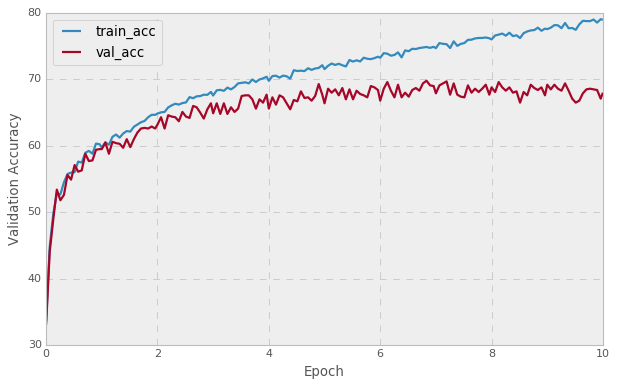

In [144]:
# plot training and test lost 
best_rnn_results = load_experiment_log(experiment_name=BEST_RNN_MODEL_NAME, filename=RESULTS_LOG)[0]['results']
plot_single_learning_curve(best_rnn_results)

In [154]:
best_rnn_results

[{'train_acc': 33.627, 'val_acc': 33.1, 'epoch': 0.0},
 {'train_acc': 44.762, 'val_acc': 44.0, 'epoch': 0.06397952655150352},
 {'train_acc': 49.723, 'val_acc': 48.9, 'epoch': 0.12795905310300704},
 {'train_acc': 52.849, 'val_acc': 53.4, 'epoch': 0.19193857965451055},
 {'train_acc': 52.673, 'val_acc': 51.8, 'epoch': 0.2559181062060141},
 {'train_acc': 54.508, 'val_acc': 52.6, 'epoch': 0.3198976327575176},
 {'train_acc': 55.762, 'val_acc': 55.6, 'epoch': 0.3838771593090211},
 {'train_acc': 55.964, 'val_acc': 54.9, 'epoch': 0.44785668586052463},
 {'train_acc': 56.033, 'val_acc': 57.1, 'epoch': 0.5118362124120281},
 {'train_acc': 57.623, 'val_acc': 56.1, 'epoch': 0.5758157389635317},
 {'train_acc': 57.473, 'val_acc': 56.3, 'epoch': 0.6397952655150352},
 {'train_acc': 58.944, 'val_acc': 58.8, 'epoch': 0.7037747920665387},
 {'train_acc': 59.235, 'val_acc': 57.7, 'epoch': 0.7677543186180422},
 {'train_acc': 58.81, 'val_acc': 57.8, 'epoch': 0.8317338451695457},
 {'train_acc': 60.33, 'val_acc':

In [146]:
# reload best model 
best_rnn_snli = rnn_model(emb_size=300, num_layers=1, hidden_size=100, fc_out_size=500, num_classes=3, 
                          pretrained_weights=pretrained_weights)
#checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(BEST_RNN_MODEL_NAME))
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(BEST_RNN_MODEL_NAME), map_location='cpu')
best_rnn_snli.load_state_dict(checkpoint)
#torch.load('encoder.pt', map_location=lambda storage, loc: storage)

In [147]:
# retest on SNLI validation set 
val_accuracy, val_predictions, val_labels = test_model(snli_val_loader, best_rnn_snli) 
print(val_accuracy)

69.1


# MNLI Dataset

#### Test Best SNLI Model on MNLI Dataset 

#### Fine-Tune Model